# 1. Problem Statement



In this assignment we are tasked with using a Convolutional Neural Network (CNN) to classify pathological images into two categories: "tumor" and "no tumor".

The images are 32 pixels by 32 pixels, and as they are in color we will have 32 * 32 * 3 input features = 3072 input features.

We are given 220,025 labeled images to use as training and validation data, as well as a test set of 57,458 unlabeled images.

In [12]:
import os

directory_path = '/kaggle/input/histopathologic-cancer-detection/test/'

if os.path.exists(directory_path):
    files = os.listdir(directory_path)

    num_files = len(files)
    print(f"Test set size: {num_files}")



Test set size: 57458


In [13]:
import numpy as np # linear algebra
import pandas as pd

train_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train_df.head()

test_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
test_df.head()

print(f"Train set size: {len(train_df)}")

Train set size: 220025


# 2. EDA

In [14]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


First, lets plot a positive and negative example.

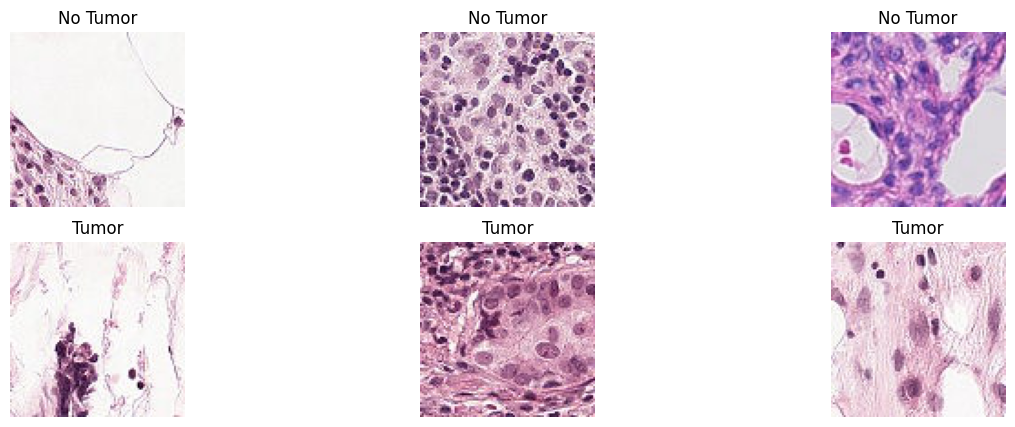

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

no_tumor_images = train_df[train_df['label'] == 0]['id'].reset_index(drop=True).head(3)

tumor_images = train_df[train_df['label'] == 1]['id'].reset_index(drop=True).head(3)

plt.figure(figsize=(15, 5))
for i, image_id in enumerate(no_tumor_images):
    plt.subplot(2, 3, i + 1)
    plt.title('No Tumor')
    plt.axis('off')
    img = mpimg.imread(f"/kaggle/input/histopathologic-cancer-detection/train/{image_id}.tif")
    plt.imshow(img)

for i, image_id in enumerate(tumor_images):
    plt.subplot(2, 3, i + 4)
    plt.title('Tumor')
    plt.axis('off')
    img = mpimg.imread(f"/kaggle/input/histopathologic-cancer-detection/train/{image_id}.tif")
    plt.imshow(img)

plt.show()


<Axes: >

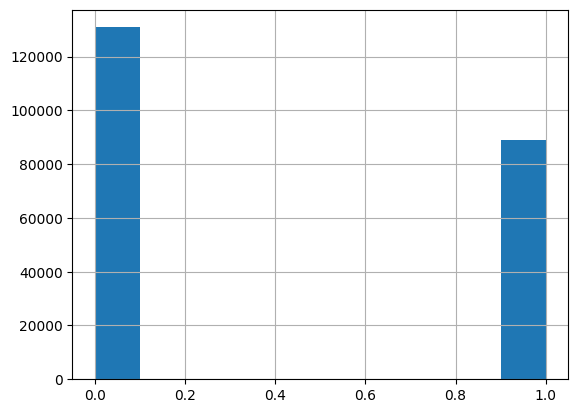

In [16]:
train_df['label'].hist()

In [17]:
train_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

We can see above that there are no missing values, and our classes are *roughly* proportional.

# 3. Modeling/Architecture

For the purposes of this assignment, this image classification task will be performed using a Convolutiona Neural Network (CNN).

To decide on an architecture, I refer to the literature and choose to start from the CNN architecture described in (Dabeer et al., 2019). In the paper, researchers achieve >99% accuracy in predicting breast cancer; however, their application differs slightly from the task of this assignment in that their images are substantially larger (350x230) and they focus specifically on *breast* cancer.

Table 1. Parameters of the CNN architecture from (Dabeer et al., 2019):

| Layer attribute | L1   | L2  | L3   | L4  | L5   | L6  |
|-----------------|------|-----|------|-----|------|-----|
| Type            | conv | pool| conv | pool| conv | pool|
| Channel         | 32   | –   | 64   | –   | 128  | –   |
| Filter Size     | 5 × 5| –   | 5 × 5| –   | 5 × 5| –   |
| Conv. stride    | 1 × 1| –   | 1 × 1| –   | 1 × 1| –   |
| Pooling size    | –    | 3 × 3| –    | 3 × 3| –    | 3 × 3|
| Pooling stride  | –    | 1 × 1| –    | 1 × 1| –    | 1 × 1|
| Padding size    | same | none| –    | none| –    | none|
| Activation      | ReLu | –   | ReLu | –   | ReLu | –   |


## 3.1 Instantiating the model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Layer 1: Convolutional layer with 32 channels, 5x5 filter size, stride 1x1, same padding, and ReLu activation
model.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# Layer 2: Max pooling layer with 3x3 pool size and stride 1x1
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

# Layer 3: Convolutional layer with 64 channels, 5x5 filter size, stride 1x1, no padding, and ReLu activation
model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='valid', activation='relu'))

# Layer 4: Max pooling layer with 3x3 pool size and stride 1x1
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

# Layer 5: Convolutional layer with 128 channels, 5x5 filter size, stride 1x1, no padding, and ReLu activation
model.add(Conv2D(128, (5, 5), strides=(1, 1), padding='valid', activation='relu'))

# Layer 6: Max pooling layer with 3x3 pool size and stride 1x1
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

model.add(Flatten())

# Fully connected layer 1 with 64 nodes and ReLu activation
model.add(Dense(64, activation='relu'))

# Fully connected layer 2 with 64 nodes and ReLu activation
model.add(Dense(64, activation='relu'))


model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 3.2 Training the model

In [8]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df["id"] = train_df["id"].apply(lambda x: x + ".tif")
train_df["label"] = train_df["label"].astype(str)

datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/histopathologic-cancer-detection/train/",
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=42,
    class_mode="binary",
    target_size=(32,32),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [19]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/histopathologic-cancer-detection/train/",
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=42,
    class_mode="binary",
    target_size=(32,32),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


epochs = 500

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5,
                               restore_best_weights=True,  
                               verbose=1)

model.fit(train_generator, 
          validation_data=valid_generator, 
          batch_size=512, 
          epochs=epochs,
          callbacks=[checkpoint, early_stopping])

Epoch 1/500
688/688 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.7654
Epoch 1: val_accuracy improved from -inf to 0.78250, saving model to best_model.h5
688/688 [==============================] - 1362s 2s/step - loss: 0.4943 - accuracy: 0.7654 - val_loss: 0.4633 - val_accuracy: 0.7825
Epoch 2/500


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


688/688 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.7991
Epoch 2: val_accuracy improved from 0.78250 to 0.80770, saving model to best_model.h5
688/688 [==============================] - 342s 497ms/step - loss: 0.4409 - accuracy: 0.7991 - val_loss: 0.4212 - val_accuracy: 0.8077
Epoch 3/500
688/688 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8091
Epoch 3: val_accuracy improved from 0.80770 to 0.81402, saving model to best_model.h5
688/688 [==============================] - 297s 432ms/step - loss: 0.4218 - accuracy: 0.8091 - val_loss: 0.4168 - val_accuracy: 0.8140
Epoch 4/500
688/688 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8195
Epoch 4: val_accuracy improved from 0.81402 to 0.82593, saving model to best_model.h5
688/688 [==============================] - 299s 435ms/step - loss: 0.4036 - accuracy: 0.8195 - val_loss: 0.3942 - val_accuracy: 0.8259
Epoch 5/500
688/688 [==============================] - ETA

### 3.2.1 Model Assessment & Tweaking
The initial validation accuracy of ~85% is impressive, but it doesn't seem to improve much as the epochs go on and training accuracy increases. This probably indicates overfitting. In order to address it, I lower the learning rate from 1e-3 to 1e-5.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Conv2D(128, (5, 5), strides=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


epochs = 500

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model_lower_lr.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5,
                               restore_best_weights=True,  
                               verbose=1)

model.fit(train_generator, 
          validation_data=valid_generator, 
          batch_size=128, 
          epochs=epochs,
          callbacks=[checkpoint, early_stopping])

Epoch 1/500
688/688 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.7819
Epoch 1: val_accuracy improved from -inf to 0.80825, saving model to best_model_lower_lr.h5
688/688 [==============================] - 284s 410ms/step - loss: 0.4684 - accuracy: 0.7819 - val_loss: 0.4188 - val_accuracy: 0.8082
Epoch 2/500


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


688/688 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.8091
Epoch 2: val_accuracy improved from 0.80825 to 0.81973, saving model to best_model_lower_lr.h5
688/688 [==============================] - 284s 414ms/step - loss: 0.4230 - accuracy: 0.8091 - val_loss: 0.3973 - val_accuracy: 0.8197
Epoch 3/500
688/688 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8199
Epoch 3: val_accuracy improved from 0.81973 to 0.82427, saving model to best_model_lower_lr.h5
688/688 [==============================] - 289s 420ms/step - loss: 0.4015 - accuracy: 0.8199 - val_loss: 0.3985 - val_accuracy: 0.8243
Epoch 4/500
688/688 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8303
Epoch 4: val_accuracy did not improve from 0.82427
688/688 [==============================] - 331s 482ms/step - loss: 0.3823 - accuracy: 0.8303 - val_loss: 0.3946 - val_accuracy: 0.8235
Epoch 5/500
688/688 [==============================] - ETA: 0s - loss: 0.37

We see above that a lower learning rate did improve the final validation accuracy albeit only slightly.

Another option might be to tweak the architecture of the model. Since our images are much smaller than those in the paper the architecture is borrowed from, we could potentially benefit from reducing the context windows from 5x5 to 3x3.

In [35]:
smaller_window_model = Sequential()
smaller_window_model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
smaller_window_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
smaller_window_model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
smaller_window_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
smaller_window_model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
smaller_window_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
smaller_window_model.add(Flatten())
smaller_window_model.add(Dense(64, activation='relu'))
smaller_window_model.add(Dense(64, activation='relu'))
smaller_window_model.add(Dense(1, activation='sigmoid'))

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


epochs = 500

smaller_window_model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model_3x3.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5,
                               restore_best_weights=True,  
                               verbose=1)

smaller_window_model.fit(train_generator, 
          validation_data=valid_generator, 
          batch_size=128, 
          epochs=epochs,
          callbacks=[checkpoint, early_stopping])

Epoch 1/500
688/688 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.7752
Epoch 1: val_accuracy improved from -inf to 0.79880, saving model to best_model_3x3.h5
688/688 [==============================] - 451s 651ms/step - loss: 0.4805 - accuracy: 0.7752 - val_loss: 0.4406 - val_accuracy: 0.7988
Epoch 2/500


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


688/688 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8055
Epoch 2: val_accuracy improved from 0.79880 to 0.80170, saving model to best_model_3x3.h5
688/688 [==============================] - 300s 436ms/step - loss: 0.4292 - accuracy: 0.8055 - val_loss: 0.4406 - val_accuracy: 0.8017
Epoch 3/500
688/688 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8227
Epoch 3: val_accuracy improved from 0.80170 to 0.83861, saving model to best_model_3x3.h5
688/688 [==============================] - 284s 413ms/step - loss: 0.3974 - accuracy: 0.8227 - val_loss: 0.3690 - val_accuracy: 0.8386
Epoch 4/500
688/688 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8335
Epoch 4: val_accuracy improved from 0.83861 to 0.84643, saving model to best_model_3x3.h5
688/688 [==============================] - 287s 417ms/step - loss: 0.3759 - accuracy: 0.8335 - val_loss: 0.3543 - val_accuracy: 0.8464
Epoch 5/500
688/688 [=========================

# 4. Results and Analysis

Reducing the window size of the model got us an extra 2% gain in accuracy, let's compare our hyperparameters:

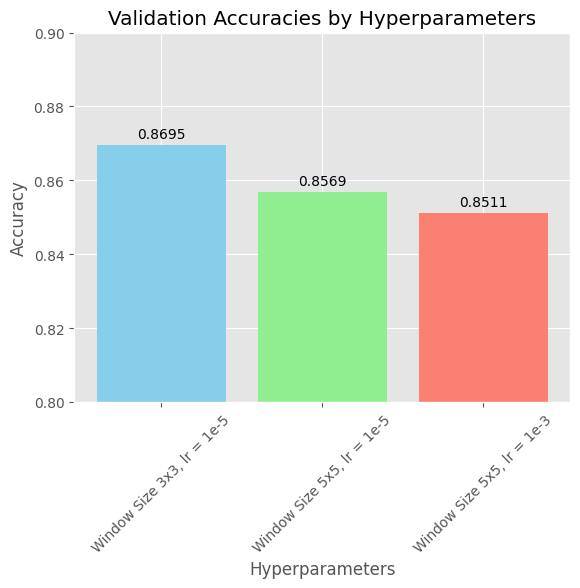

In [41]:
import matplotlib.pyplot as plt

values = [0.8695, 0.8569, 0.85115]
labels = ['Window Size 3x3, lr = 1e-5', 'Window Size 5x5, lr = 1e-5', 'Window Size 5x5, lr = 1e-3']

plt.style.use('ggplot')
bars = plt.bar(labels, values, color=['skyblue', 'lightgreen', 'salmon'])

plt.xticks(rotation=45) 

plt.title('Validation Accuracies by Hyperparameters')
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')


plt.ylim(0.80, 0.90)


for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f'{value:.4f}', ha='center', va='bottom')

plt.show()


We can also look at the confusion matrix of our best model:

In [42]:
predictions = smaller_window_model.predict(valid_generator)

binary_predictions = (predictions > 0.5).astype(int)
true_labels = valid_generator.classes

TP = sum((binary_predictions == 1) & (true_labels == 1))
FP = sum((binary_predictions == 1) & (true_labels == 0))
TN = sum((binary_predictions == 0) & (true_labels == 0))
FN = sum((binary_predictions == 0) & (true_labels == 1))


172/172 [==============================] - 64s 370ms/step


# 5. Conclusion

In conclusion, with the architecture modifications made in this assignment we were able to predict tumors in images with ~87% accuracy.

The key takeaways are:
* The importance of experimenting with different hyperparameters to achieve maximal performance.
* The utility of working off of previous work.

# References
Dabeer, S., Khan, M. M., & Islam, S. (2019). Cancer diagnosis in histopathological image: CNN based approach. *Informatics in Medicine Unlocked*. https://doi.org/10.1016/j.imu.2019.100231